# Description 
- Nội dung: dữ liệu ghi lại thông tin các vụ phóng tên lửa từ năm 1957
- Nguồn: https://www.kaggle.com/agirlcoding/all-space-missions-from-1957
- Cách thức dữ liệu được lấy: dữ liệu được scrap từ trang https://nextspaceflight.com/launches/past/?page=1 bằng BeautifulSoup từ ngày 7/8/2020 trở về trước
- Usage Information: License: Unknow, Visibility: Public
- Dataset owner: https://www.kaggle.com/agirlcoding

# Import libraries

In [76]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Import file

In [77]:
spaceLaunch_df = pd.read_csv("Space_Corrected.csv")
spaceLaunch_df.head()

,Unnamed: 0,Unnamed: 0.1,Company Name,Location,Datum,Detail,Status Rocket,Rocket,Status Mission
0,0,0,SpaceX,"LC-39A, Kennedy Space Center, Florida, USA","Fri Aug 07, 2020 05:12 UTC",Falcon 9 Block 5 | Starlink V1 L9 & BlackSky,StatusActive,50.0,Success
1,1,1,CASC,"Site 9401 (SLS-2), Jiuquan Satellite Launch Ce...","Thu Aug 06, 2020 04:01 UTC",Long March 2D | Gaofen-9 04 & Q-SAT,StatusActive,29.75,Success
2,2,2,SpaceX,"Pad A, Boca Chica, Texas, USA","Tue Aug 04, 2020 23:57 UTC",Starship Prototype | 150 Meter Hop,StatusActive,NaN,Success
3,3,3,Roscosmos,"Site 200/39, Baikonur Cosmodrome, Kazakhstan","Thu Jul 30, 2020 21:25 UTC",Proton-M/Briz-M | Ekspress-80 & Ekspress-103,StatusActive,65.0,Success
4,4,4,ULA,"SLC-41, Cape Canaveral AFS, Florida, USA","Thu Jul 30, 2020 11:50 UTC",Atlas V 541 | Perseverance,StatusActive,145.0,Success


# Explore

## Kích thước của file

In [78]:
spaceLaunch_df.shape

(4324, 9)

## Các cột của dữ liệu

In [79]:
spaceLaunch_df.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'Company Name', 'Location', 'Datum',
       'Detail', 'Status Rocket', ' Rocket', 'Status Mission'],
      dtype='object')

## Kiểu dữ liệu của các cột

In [80]:
spaceLaunch_df.dtypes

Unnamed: 0         int64
Unnamed: 0.1       int64
Company Name      object
Location          object
Datum             object
Detail            object
Status Rocket     object
 Rocket           object
Status Mission    object
dtype: object

## Tỉ lệ giá trị rỗng trong từng cột

In [81]:
for column in spaceLaunch_df.columns:
    print(column, str(round( 100* spaceLaunch_df[column].isnull().sum() / len(spaceLaunch_df[column]),2)) + '%')

Unnamed: 0 0.0%
Unnamed: 0.1 0.0%
Company Name 0.0%
Location 0.0%
Datum 0.0%
Detail 0.0%
Status Rocket 0.0%
 Rocket 77.71%
Status Mission 0.0%


## Ý nghĩa các cột dữ liệu
- Unnamed: 0,Unnamed: 0.1: (int) trường index
- Company Name: (str) tên của công ty thực hiện vụ phóng
- Location: (object) địa điểm xảy ra vụ phóng
- Datum: (object) Thời điểm vụ phóng xả ra
- Detail: (object) Tên của tên lửa / tên của vệ tinh được phóng bằng tên lửa
- Status Rocket: (object) Tình trạng của tên lửa (đang còn sử dụng/không còn sử dụng)
- Rocket: (object) Chi phí cho tên lửa
- Status Mission: (object) Kết quả của vụ phóng
    

In [82]:
# Xác định các kiểu dữ liệu có thể có của object
def open_object_dtype(s):
    dtypes = set()
    
    # YOUR CODE HERE
    for i in range(len(s)):
        dtypes.add(type(s.iloc[i]))
    
    return dtypes

In [83]:
columns = ["Company Name","Location","Datum","Detail","Status Rocket"," Rocket","Status Mission"]
for column in columns:
    print("columns name: " + column)
    print("unique values: " + str(len(spaceLaunch_df[column].unique())))
    print("data type: " + str(open_object_dtype(spaceLaunch_df[column])))
    print()

columns name: Company Name
unique values: 56
data type: {<class 'str'>}

columns name: Location
unique values: 137
data type: {<class 'str'>}

columns name: Datum
unique values: 4319
data type: {<class 'str'>}

columns name: Detail
unique values: 4278
data type: {<class 'str'>}

columns name: Status Rocket
unique values: 2
data type: {<class 'str'>}

columns name:  Rocket
unique values: 57
data type: {<class 'float'>, <class 'str'>}

columns name: Status Mission
unique values: 4
data type: {<class 'str'>}



# Data Preprocessing

## Loại bỏ

In [84]:
#Bỏ đi 2 cột Unnamed: 0 và Unnamed: 0.1 vì không cần thiết
del spaceLaunch_df["Unnamed: 0"]
del spaceLaunch_df["Unnamed: 0.1"]

## Thêm cột

In [85]:
#Cột Datum là kiểu dữ liệu object cần được chuyển sang dạng datetime
spaceLaunch_df["Datum"] = pd.to_datetime(spaceLaunch_df["Datum"])

#Tạo thêm cột month, year
spaceLaunch_df["year"] = spaceLaunch_df["Datum"].apply(lambda datetime: datetime.year)
spaceLaunch_df["month"] = spaceLaunch_df["Datum"].apply(lambda datetime: datetime.month)

#Tạo thêm cột country
spaceLaunch_df["country"] = spaceLaunch_df["Location"].apply(lambda country: country.split(", ")[-1])

## Điều chỉnh cột

In [86]:
#Tên cột Rocket bị dư một dấu cách phía trước, không để ý có thể gây lỗi nên cần được bỏ dấu cách đi
spaceLaunch_df = spaceLaunch_df.rename(columns= {" Rocket" : "Rocket"})

#Convert cột rocket sang kiểu Float và lấp những giá trị null bằng 0
spaceLaunch_df["Rocket"] = spaceLaunch_df["Rocket"].astype(str)
for i in range(len(spaceLaunch_df["Rocket"])):
    spaceLaunch_df["Rocket"][i] = spaceLaunch_df["Rocket"][i].strip(", ")
    spaceLaunch_df["Rocket"][i] = spaceLaunch_df["Rocket"][i].replace(",","")
spaceLaunch_df["Rocket"] = spaceLaunch_df["Rocket"].astype(float)
spaceLaunch_df["Rocket"] = spaceLaunch_df["Rocket"].fillna(0)

C:\Users\Admin\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Admin\anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [87]:
#Các nhiệm vụ phóng được thực hiện tại Kazakhstan đều được thực hiện bởi các công ty Nga
#nên ta cần đổi giá trị của cột country mà là Kazakhstan thành Russia mà trước năm 1991 là Liên Xô (USSR)
for i in range(len(spaceLaunch_df["country"])):
    if (spaceLaunch_df["country"].loc[i] == "Kazakhstan"):
        if(spaceLaunch_df["year"].loc[i] < 1991):
            spaceLaunch_df["country"].loc[i] = "USSR"
        else:
            spaceLaunch_df["country"].loc[i] = "Russia"
    # Một vài đại điểm phóng tại Nga trước năm 1991 vẫn lưu là Nga nên ta đổi thành USSR
    if (spaceLaunch_df["country"].loc[i] == "Russia" and spaceLaunch_df["year"].loc[i] < 1991):
        spaceLaunch_df["country"].loc[i] = "USSR"

#Tương tự với một số địa điểm khác trên thế giới
spaceLaunch_df.loc[spaceLaunch_df['country'] == 'New Mexico', 'country'] = 'USA'
spaceLaunch_df.loc[spaceLaunch_df['country'] == "Yellow Sea", 'country'] = "China"
spaceLaunch_df.loc[spaceLaunch_df['country'] == "Shahrud Missile Test Site", 'country'] = "Iran"
spaceLaunch_df.loc[spaceLaunch_df['country'] == "Pacific Missile Range Facility", 'country'] = "USA"
spaceLaunch_df.loc[spaceLaunch_df['country'] == "Barents Sea", 'country'] = 'Russia'
spaceLaunch_df.loc[spaceLaunch_df['country'] == "Gran Canaria", 'country'] = 'USA'

C:\Users\Admin\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## Dữ liệu sau tiền xử lý

In [88]:
spaceLaunch_df.head(5)

,Company Name,Location,Datum,Detail,Status Rocket,Rocket,Status Mission,year,month,country
0,SpaceX,"LC-39A, Kennedy Space Center, Florida, USA",2020-08-07 05:12:00+00:00,Falcon 9 Block 5 | Starlink V1 L9 & BlackSky,StatusActive,50.00,Success,2020,8,USA
1,CASC,"Site 9401 (SLS-2), Jiuquan Satellite Launch Ce...",2020-08-06 04:01:00+00:00,Long March 2D | Gaofen-9 04 & Q-SAT,StatusActive,29.75,Success,2020,8,China
2,SpaceX,"Pad A, Boca Chica, Texas, USA",2020-08-04 23:57:00+00:00,Starship Prototype | 150 Meter Hop,StatusActive,0.00,Success,2020,8,USA
3,Roscosmos,"Site 200/39, Baikonur Cosmodrome, Kazakhstan",2020-07-30 21:25:00+00:00,Proton-M/Briz-M | Ekspress-80 & Ekspress-103,StatusActive,65.00,Success,2020,7,Russia
4,ULA,"SLC-41, Cape Canaveral AFS, Florida, USA",2020-07-30 11:50:00+00:00,Atlas V 541 | Perseverance,StatusActive,145.00,Success,2020,7,USA


In [89]:
spaceLaunch_df.dtypes

Company Name       object
Location           object
Datum              object
Detail             object
Status Rocket      object
Rocket            float64
Status Mission     object
year                int64
month               int64
country            object
dtype: object

# Analysis

## Question 1: Diễn biến hiện tại của cuộc lên vũ trụ như thế nào?
Ý nghĩa: Trả lời cho câu hỏi sẽ giúp ta có cái nhìn tổng quan hơn về cuộc đua lên vũ trụ của các nước trên thế giới, đây là một chủ đề khá thú vị vì Việt Nam chúng ta cũng đã thực hiện phóng 2 vệ tinh mang tên Vinasat-1 và Vinasat-2 năm 2008 và 2012, chúng ta nên biết vị trí của chúng ta đang ở đâu để có thể cố gắng hơn nữa để đưa Việt Nam sánh ngang cường quốc năm châu

### Ta tìm xem thử 2 vệ tinh Vinasat-1 và Vinasat-2 của Việt Nam

In [90]:
#Ta tìm xem thử 2 vệ tinh Vinasat-1 và Vinasat-2 của Việt Nam
for i in range(spaceLaunch_df.shape[0]):
    if spaceLaunch_df.iloc[i]["Detail"].find("Vinasat") != -1:
        #2 vệ tinh này do Pháp phóng nhưng vẫn là tài sản của Việt Nam nên mình sẽ đổi tên trường country thành Việt Nam
        spaceLaunch_df.iloc[i]["country"] = "Viet Nam"
        print(spaceLaunch_df.iloc[i])

C:\Users\Admin\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Company Name                                            Arianespace
Location          ELA-3, Guiana Space Centre, French Guiana, France
Datum                                     2012-05-15 22:13:00+00:00
Detail                           Ariane 5 ECA | JCSAT-13, Vinasat-2
Status Rocket                                          StatusActive
Rocket                                                          200
Status Mission                                              Success
year                                                           2012
month                                                             5
country                                                      France
Name: 649, dtype: object
Company Name                                            Arianespace
Location          ELA-3, Guiana Space Centre, French Guiana, France
Datum                                     2008-04-18 22:17:00+00:00
Detail                       Ariane 5 ECA | Star One C2 & Vinasat-1
Status Rocket          

### Tỉ lệ tên lửa đang còn hoạt động của các quốc gia trên thế giới

Text(0.5, 0, 'Number of active rocket')

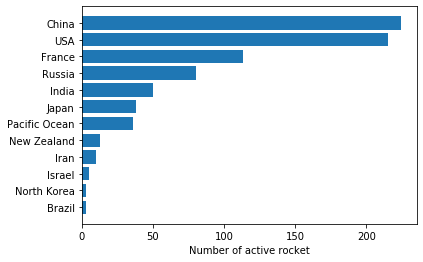

In [91]:
#Tỉ lệ tên lửa đang còn hoạt động của các quốc gia trên thế giới
active_df = spaceLaunch_df[spaceLaunch_df["Status Rocket"] == "StatusActive"]
active_country_df = active_df.groupby("country")["Status Rocket"].count().sort_values().reset_index()
plt.barh(active_country_df["country"],active_country_df["Status Rocket"])
plt.xlabel("Number of active rocket")

Với số lượng là 2 vệ tinh thì có lẽ chúng ta đang còn thua xa các cường quốc khác

### Biểu đồ các nước dẫn đầu trong cuộc đua lên vũ trụ qua từng năm

In [92]:
launchCountry = spaceLaunch_df.groupby(["year","country"])["Status Mission"].count()
launchCountry = launchCountry.reset_index().sort_values(["year","Status Mission"],ascending = False)
launchCountry = pd.concat([group[1].head(1) for group in launchCountry.groupby(['year'])])

#Biểu đồ các nước dẫn đầu trong cuộc đua lên vũ trụ qua từng năm dựa theo số vụ phóng trong năm đó
fig = px.bar(launchCountry, x="year", y="Status Mission", color='country',
             title = "Biểu đồ các nước dẫn đầu trong cuộc đua lên vũ trụ qua từng năm")
fig.show()

Mình khá bất ngờ với kết quả này vì bình thường trên truyền thông ta được nghe nhiều hơn về các vụ phóng của các
cường quốc như Mỹ, Nga, Ấn Độ nhưng thật không ngờ Trung Quốc đã vượt mặt các cường quốc trên trong những năm gần đây 
cả về tổng số nhiệm vụ phóng và cả về tổng số vệ tinh đang hoạt động trên quỹ đạo, điều này dẫn đến một thắc mắc nữa của mình là từ khi nào và từ đâu?

## Question 2: Từ khi nào và nhờ đâu Trung Quốc vươn lên dẫn đầu ngành công nghiệp vũ trụ như vậy? 
Ý nghĩa: sau khi ta trả lời câu hỏi trên ta sẽ thấy được sự vươn lên mạnh mẽ của Trung Quốc trong ngành công nghiệp hàng không vũ trụ rồi từ đó có thể mở rộng ra các lĩnh vực khác để có cái nhìn bao quát hơn về sự phát triển của Trung Quốc. Đó sẽ là thông tin, bài học quý giá cho Việt Nam chúng ta bởi vì biết người biết ta, trăm trận trăm thắng.

### Biểu đồ số nhiệm vụ phóng tàu ra vũ trụ của các cường quốc

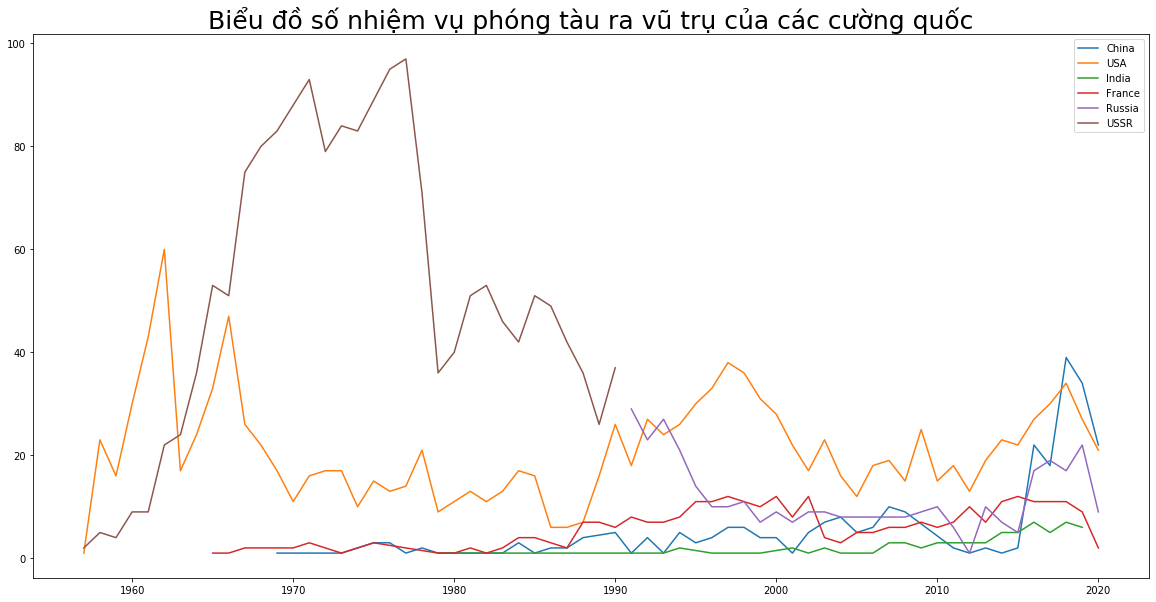

In [93]:
#Ta lấy kết quả từ câu 1 để lấy ra 5 nước top đầu rồi vẽ biểu đồ lịch sử nhiệm vụ phóng tàu ra vũ trụ
launch_Country = spaceLaunch_df.groupby(["country","year"])["Status Mission"].count().reset_index()
launch_Country = launch_Country.rename(columns= {"Status Mission" : "launch"})
plt.figure(figsize = (20,10))
countries = ["China","USA","India","France","Russia","USSR"]
for country in countries:
    plt.plot(launch_Country[launch_Country["country"] == country]["year"],
             launch_Country[launch_Country["country"] == country]["launch"], label = country)
    
plt.title("Biểu đồ số nhiệm vụ phóng tàu ra vũ trụ của các cường quốc", fontdict = {'fontsize':25})
plt.legend()


Từ biểu đồ này ta có thể thấy trước 2017 gần như là Mỹ và Nga thay nhau đứng đầu về số lượng nhiệm vụ ra ngoài không gian, nhưng những năm gần đây thì Trung Quốc lại nổi lên một cách mạnh mẽ vượt qua 2 cường quốc kia dù là nước đi sau trong cuộc đua không gian này, liệu ta có thể hiểu thêm bằng cách phân tích cuộc đua của các công ty qua các năm?

### Các công ty lớn của Trung Quốc và số nhiệm vụ phóng đã hoàn thành

<BarContainer object of 6 artists>

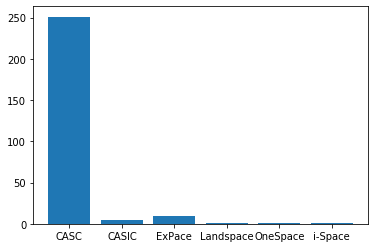

In [26]:
spaceLaunch_China_df = spaceLaunch_df[spaceLaunch_df["country"] == "China"]
China_companies = spaceLaunch_China_df.groupby(["Company Name"])["Status Mission"].count()
plt.bar(China_companies.index,China_companies.values)
plt.title("Các công ty lớn của Trung Quốc và số nhiệm vụ phóng đã hoàn thành")

CASC là một công ty nhà nước của Trung Quốc về khoa học hàng không vũ trụ, ta xem xét thử sự phát triển của công ty này

### Biểu đồ số năm kinh nghiệm phóng tàu vũ trụ của top 10 các công ty về hàng không vũ

<BarContainer object of 10 artists>

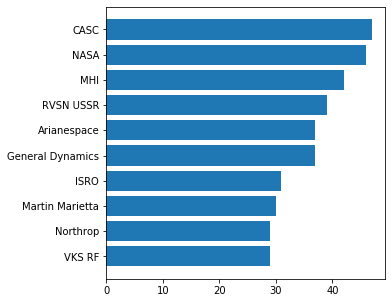

In [27]:
#Biểu đồ số năm kinh nghiệm phóng tàu vũ trụ của top 10 các công ty về hàng không vũ trụ dựa theo số năm phóng 
companies_exp_df = spaceLaunch_df.groupby(["Company Name"])["year"].nunique().sort_values().tail(10)
plt.figure(figsize = (5,5))
plt.barh(companies_exp_df.index,companies_exp_df.values)

Có thể thấy rằng công ty này của Trung Quốc có tuổi đời kinh nghiệm trong việc phóng tàu vũ trụ lâu nhất trong các công ty lớn

### Số các vụ phóng của CASC qua từng năm

<BarContainer object of 47 artists>

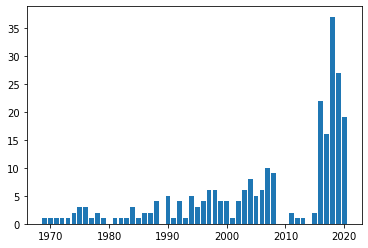

In [28]:
CASC = spaceLaunch_China_df[spaceLaunch_China_df["Company Name"] == "CASC"]
CASC = CASC.groupby("year")["Status Mission"].count().reset_index()
plt.bar(CASC["year"],CASC["Status Mission"])

Nếu kết hợp với việc tìm kiếm thông tin trên google về sự phát triển của khoa học công nghệ ở Trung Quốc thì cũng thấy có sự tương đồng về thời điểm khi năm 2016 cũng là năm Trung Quốc vượt mặt Mỹ và là nước có sống lượng bài báo khoa học được công bố nhiều nhất trên thế giới và là năm Trung Quốc thông qua luật an ninh mạng quốc gia yêu cầu mọi công ty nước ngoài làm ăn tại Trung Quốc phải lưu ít nhất 6 tháng dữ liệu ngay bên trong Trung Quốc. Cho thấy Trung Quốc có tham vọng rất to lớn kiểm soát thông tin trong nước và trở thành một cường quốc công nghệ trên thế giới, mặt khác số lượng tên lửa được phóng ra ngoài không gian tăng vọt có thể liên quan đến sự đầu tư, phát triển, áp dụng rộng rãi của công nghệ trí tuệ nhân tạo, nhận diện khuôn mặt và hệ thống giám sát, chấm điểm công dân của Trung Quốc, gây ra nhiều tranh cãi trong cộng đồng quốc tế. Từ đó có thể suy ra nguyên nhân ngành công nghiệp hàng không vũ trụ của Trung Quốc phát triển mạnh là nhờ kinh nghiệm lâu năm, sự phát triển mạnh mẽ của khoa học trong nước cùng sự đầu tư mạnh mẽ của chính phủ nhằm các mục đích an ninh, chính trị, kinh tế khác.

## Question 3: Sự phát triển của ngành công nghiệp khoa học vũ trụ sẽ đi đến đâu? 

- Ta sẽ dự đoán sự phát triển của 3 cường quốc trong top 3 trong 5 năm tới tính theo số lượng phóng tàu của mỗi nước
bằng cách dùng mô hình ARIMA
- Ý nghĩa: việc dự đoán sẽ cho những đối thủ trong ngành một sự chuẩn bị và động lực để tăng cường phát triển sáng tạo để có thể vượt qua đối thủ của mình. Việc hiểu biết đối thủ của mình là ai và sẽ như thế nào là một yếu tố rất quan trọng trong một cuộc đua

### Biểu đồ số nhiệm vụ phóng tàu ra vũ trụ của các cường quốc

Text(0.5, 0, 'Year')

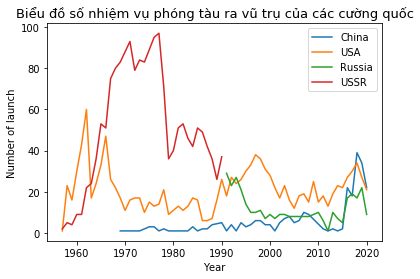

In [95]:
#Biểu đồ số vụ phóng của Mỹ, Nga, Trung Quốc, sử dụng là dataFrame launch_Country của câu 2 trước
countries = ["China","USA","Russia","USSR"]
for country in countries:
    plt.plot(launch_Country[launch_Country["country"] == country]["year"],
             launch_Country[launch_Country["country"] == country]["launch"], label = country)
    
plt.title("Biểu đồ số nhiệm vụ phóng tàu ra vũ trụ của các cường quốc", fontdict = {'fontsize':13})
plt.legend()
plt.ylabel("Number of launch")
plt.xlabel("Year")

### Dự báo cho sự phát triển của Trung Quốc

In [97]:
China_data_df = launch_Country[launch_Country["country"] == "China"]
China_data_df = China_data_df[China_data_df["year"] < 2020]
China_data_df = China_data_df.rename(columns= {"Status Misson" : "launch"})
model = ARIMA(China_data_df["launch"], order=(3,1,1))
#Ở đây ta chọn chỉ số p,d,q là 3 1 1 vì:
#p = 3: sau 3 lần sai phân ta mới thấy độ lệch của biểu đồ PACF đủ lớn
#d = 1: trong quá trình phân tích chuỗi thời gian, ta thấy biểu đồ ACF đạt được trạng thái ổn định sau 1 lần sai phân
#q = 1: quan sát lại biểu đồ ACF ta thấy độ lệch không nhiều nên đặt là q = 1
model_fit = model.fit(disp=0)
model_fit.summary()

C:\Users\Admin\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

C:\Users\Admin\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.



<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:               D.launch   No. Observations:                   46
Model:                 ARIMA(3, 1, 1)   Log Likelihood                -130.540
Method:                       css-mle   S.D. of innovations              4.098
Date:                Fri, 28 Aug 2020   AIC                            273.080
Time:                        16:58:06   BIC                            284.052
Sample:                             1   HQIC                           277.190
                                                                              
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.9907      0.929      1.066      0.286      -0.831       2.812
ar.L1.D.launch    -0.3028      1.412     -0.214      0.830      -3.071       2.466
ar.L2.D.launch     0.5028      0.348      1.444      0.149      -0.180       1.185
ar.L3.D.launch     0.1048      0.739      0.142      0.887      -1.343       1.553
ma.L1.D.launch     0.0817      1.408      0.058      0.954      -2.679       2.842
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.4837           +0.0000j            1.4837            0.0000
AR.2           -1.2878           +0.0000j            1.2878            0.5000
AR.3           -4.9924           +0.0000j            4.9924            0.5000
MA.1          -12.2438           +0.0000j           12.2438            0.5000
-----------------------------------------------------------------------------
"""

Quan sát sơ lược trên ta thấy chỉ số P > |z| của AR 3 khá lớn nên điều chỉnh Model giảm xuống AR 2

In [31]:
model = ARIMA(China_data_df["launch"], order=(2,2,1))
model_fit = model.fit(disp=0)
model_fit.summary()

C:\Users\Admin\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

C:\Users\Admin\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.



<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:              D2.launch   No. Observations:                   45
Model:                 ARIMA(2, 2, 1)   Log Likelihood                -128.589
Method:                       css-mle   S.D. of innovations              4.029
Date:                Fri, 28 Aug 2020   AIC                            267.178
Time:                        14:59:09   BIC                            276.211
Sample:                             2   HQIC                           270.545
                                                                              
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0949      0.058      1.635      0.102      -0.019       0.209
ar.L1.D2.launch    -0.2308      0.137     -1.688      0.091      -0.499       0.037
ar.L2.D2.launch     0.4999      0.166      3.003      0.003       0.174       0.826
ma.L1.D2.launch    -1.0000      0.079    -12.590      0.000      -1.156      -0.844
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.2023           +0.0000j            1.2023            0.5000
AR.2            1.6640           +0.0000j            1.6640            0.0000
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

Ta thấy chỉ số AIC đã giảm và P > |z| của AR 2 và MA 1 khá tốt

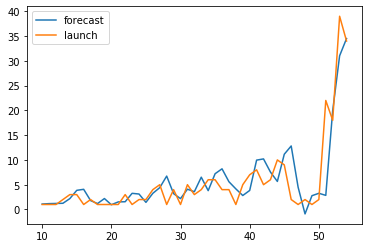

In [32]:
model_fit.plot_predict(dynamic=False)
plt.show()

Text(0.5, 1.0, 'Dự báo số nhiệm vụ phóng cho Trung Quốc trong 5 năm tới')

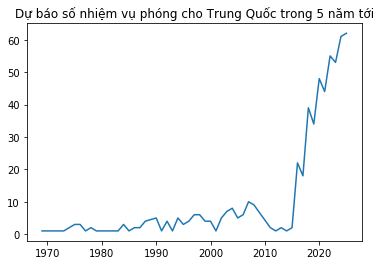

In [33]:
preds, _, _ = model_fit.forecast(6, alpha=0.05)
preds = preds.tolist()
preds = [int(item) for item in preds]
years = ['2020', '2021', '2022', '2023', '2024', '2025']

new_df = pd.DataFrame()
new_df['year'] = years
new_df["launch"] = preds
China_data = China_data_df[["year","launch"]]
China_data = pd.concat([China_data, new_df])
plt.plot(China_data["year"], China_data["launch"])
plt.title("Dự báo số nhiệm vụ phóng cho Trung Quốc trong 5 năm tới")

### Dự báo cho sự phát triển của Hoa Kỳ

In [34]:
USA_data_df = launch_Country[launch_Country["country"] == "USA"][launch_Country["year"] < 2020]
model = ARIMA(USA_data_df["launch"], order=(1,1,1))
#Các xác định p,d,q tương tự như câu dự đoán Trung Quốc
model_fit = model.fit(disp=0)
model_fit.summary()

C:\Users\Admin\anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

C:\Users\Admin\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

C:\Users\Admin\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.



<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:               D.launch   No. Observations:                   62
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -221.163
Method:                       css-mle   S.D. of innovations              8.383
Date:                Fri, 28 Aug 2020   AIC                            450.325
Time:                        14:59:09   BIC                            458.834
Sample:                             1   HQIC                           453.666
                                                                              
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0673      0.145      0.463      0.643      -0.218       0.352
ar.L1.D.launch     0.6248      0.108      5.768      0.000       0.412       0.837
ma.L1.D.launch    -1.0000      0.047    -21.317      0.000      -1.092      -0.908
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.6006           +0.0000j            1.6006            0.0000
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

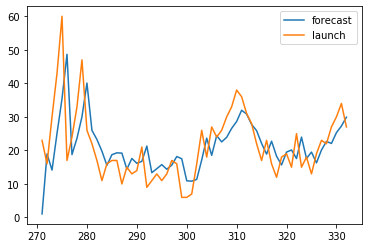

In [35]:
model_fit.plot_predict(dynamic=False)
plt.show()

Text(0.5, 1.0, 'Dự báo số nhiệm vụ phóng cho Hoa Kỳ trong 5 năm tới')

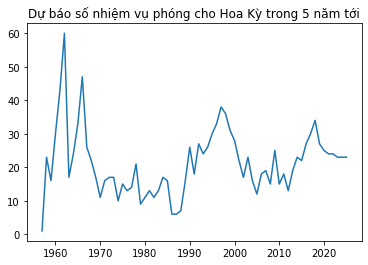

In [36]:
preds, _, _ = model_fit.forecast(6, alpha=0.05)
preds = preds.tolist()
preds = [int(item) for item in preds]
years = ['2020', '2021', '2022', '2023', '2024', '2025']

new_df = pd.DataFrame()
new_df['year'] = years
new_df["launch"] = preds
USA_data = USA_data_df[["year","launch"]]
USA_data = pd.concat([USA_data, new_df])
plt.plot(USA_data["year"], USA_data["launch"])
plt.title("Dự báo số nhiệm vụ phóng cho Hoa Kỳ trong 5 năm tới")

### Dự báo cho sự phát triển của Nga

In [37]:
#Ta thực hiện gộp dữ liệu của Nga và Liên Xô lại
Russia_data_df = launch_Country[launch_Country["country"] == "Russia"][launch_Country["year"] < 2020].append(
launch_Country[launch_Country["country"] == "USSR"][launch_Country["year"] < 2020])

C:\Users\Admin\anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

C:\Users\Admin\anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



In [38]:
Russia_data_df = Russia_data_df.sort_values("year").reset_index()[["year","launch"]]
model = ARIMA(Russia_data_df["launch"], order=(1,0,0))
#Các xác định p,d,q tương tự như câu dự đoán Trung Quốc
model_fit = model.fit(disp=0)
model_fit.summary()
# # plt.plot(Russia_data_df["year"],Russia_data_df["Status Mission"])

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                 launch   No. Observations:                   63
Model:                     ARMA(1, 0)   Log Likelihood                -225.702
Method:                       css-mle   S.D. of innovations              8.542
Date:                Fri, 28 Aug 2020   AIC                            457.403
Time:                        14:59:09   BIC                            463.833
Sample:                             0   HQIC                           459.932
                                                                              
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           25.0972     17.639      1.423      0.155      -9.475      59.669
ar.L1.launch     0.9511      0.032     29.271      0.000       0.887       1.015
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0515           +0.0000j            1.0515            0.0000
-----------------------------------------------------------------------------
"""

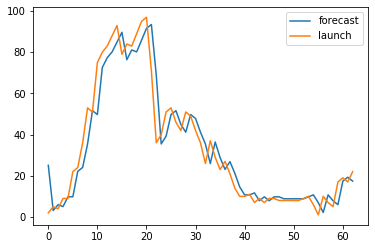

In [39]:
model_fit.plot_predict(dynamic=False)
plt.show()

Text(0.5, 1.0, 'Dự báo số nhiệm vụ phóng cho Nga trong 5 năm tới')

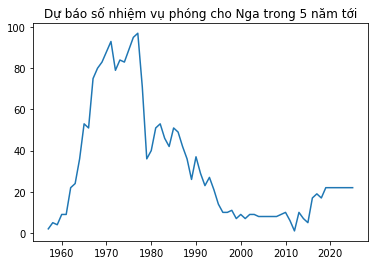

In [40]:
preds, _, _ = model_fit.forecast(6, alpha=0.05)
preds = preds.tolist()
preds = [int(item) for item in preds]
years = ['2020', '2021', '2022', '2023', '2024', '2025']

new_df = pd.DataFrame()
new_df['year'] = years
new_df["launch"] = preds
Russia_data = Russia_data_df[["year","launch"]]
Russia_data = pd.concat([Russia_data, new_df])
plt.plot(Russia_data["year"], Russia_data["launch"])
plt.title("Dự báo số nhiệm vụ phóng cho Nga trong 5 năm tới")

### Dự báo cho sự phát triển của ngành hàng không vũ trụ của 3 cường quốc theo số nhiệm vụ phóng sẽ thực hiện trong 5 năm tới

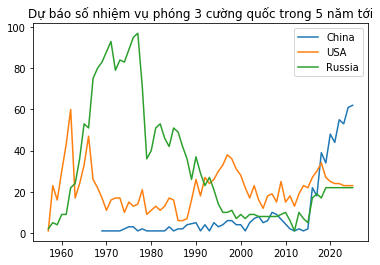

In [41]:
plt.plot(China_data["year"], China_data["launch"],label = "China")
plt.plot(USA_data["year"], USA_data["launch"],label = "USA")
plt.plot(Russia_data["year"], Russia_data["launch"],label = "Russia")
plt.title("Dự báo số nhiệm vụ phóng 3 cường quốc trong 5 năm tới")
plt.legend()

Theo như mô hình của mình dự báo có vẻ trong 5 năm tới, Trung Quốc sẽ vượt xa trong cuộc đua này còn Nga và Mỹ thì có vẻ lại dậm chân tại chỗ. Một điều chắc chắn rằng Nga và Mỹ nên cố gắng có những phát triển và tiến bộ hơn nữa nếu không muốn bị Trung Quốc bỏ xa trong cuộc đua này